In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import re
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from Common.functions import evaluate_model, train_model
from Common.custom_dataset import CustomDataset
from Common.ffnn import FFNN
from Common.rnn import RNN


[nltk_data] Downloading package punkt to /Users/ali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Dataset

In [2]:
# Load the train set
train_data = pd.read_csv("../Data/arxiv_train.csv")
print("\nShape of X_train:", train_data.shape)
print(f"\n{train_data.head(5)}")


Shape of X_train: (80000, 3)

   Unnamed: 0                                           abstract     label
0       31716    Automatic meeting analysis is an essential f...      eess
1       89533    We propose a protocol to encode classical bi...  quant-ph
2       82700    A number of physically intuitive results for...  quant-ph
3       78830    In the last decade rare-earth hexaborides ha...   physics
4       94948    We introduce the weak barycenter of a family...      stat


In [3]:
# Load the train set
test_data = pd.read_csv("../Data/arxiv_test.csv")
print("Shape of X_test:", test_data.shape)
print(f"\n{test_data.head(5)}")

Shape of X_test: (20000, 3)

   Unnamed: 0                                           abstract   label
0       64481    We describe a shape derivative approach to p...    math
1       48104    We study displaced signatures of sneutrino p...  hep-ph
2       48233    High precision studies of Beyond-Standard-Mo...  hep-ph
3       49026    We find that a class of models of MeV-GeV da...  hep-ph
4       37957    Knowledge of power grid's topology during ca...    eess


### Data Cleaning

In [4]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    tokens = word_tokenize(text.lower())  # Tokenize the text
    stop_words = set(stopwords.words('english'))  # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()  # Lemmatize each word
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    stemmer = PorterStemmer()  # Stem each word
    tokens = [stemmer.stem(word) for word in tokens]
    clean_text = ' '.join(tokens)  # Join tokens back into a single string
    return clean_text

train_data['clean_abstract'] = train_data['abstract'].apply(clean_text)
test_data['clean_abstract'] = test_data['abstract'].apply(clean_text)


In [5]:
train_data.head(5)

,Unnamed: 0,abstract,label,clean_abstract
0,31716,Automatic meeting analysis is an essential f...,eess,automat meet analysi essenti fundament technol...
1,89533,We propose a protocol to encode classical bi...,quant-ph,propos protocol encod classic bit measur stati...
2,82700,A number of physically intuitive results for...,quant-ph,number physic intuit result calcul multitim co...
3,78830,In the last decade rare-earth hexaborides ha...,physics,last decad rareearth hexaborid investig fundam...
4,94948,We introduce the weak barycenter of a family...,stat,introduc weak barycent famili probabl distribu...


In [6]:
research_fields = sorted(train_data["label"].unique())

print("Research Fields")
for i, element in enumerate(research_fields, start=1):
    print(f"{i}. {element}")

Research Fields
1. astro-ph
2. cond-mat
3. cs
4. eess
5. hep-ph
6. hep-th
7. math
8. physics
9. quant-ph
10. stat


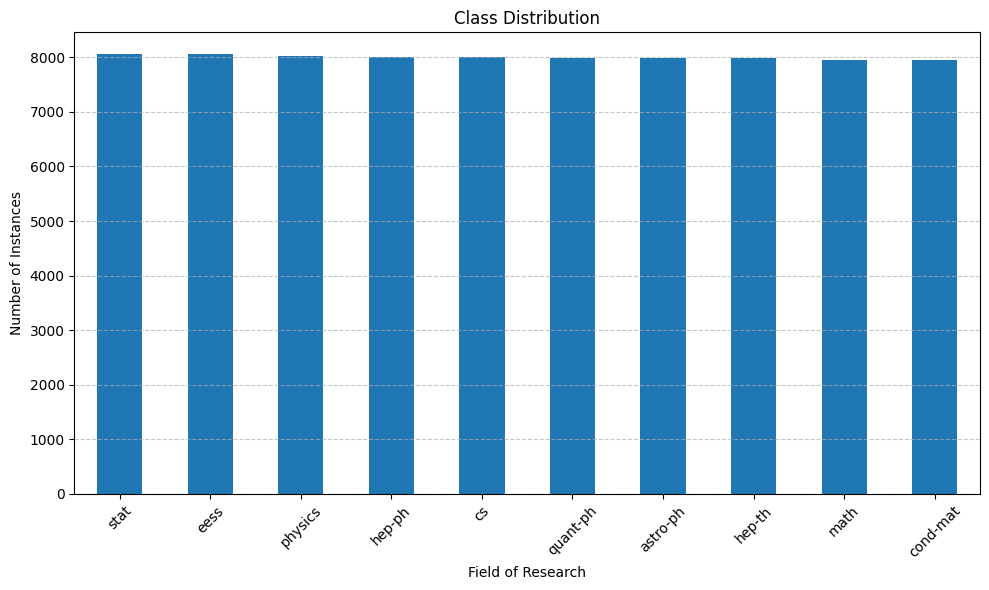

In [7]:
# Calculate class distribution
class_distribution = train_data['label'].value_counts()

# Plot class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Field of Research')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

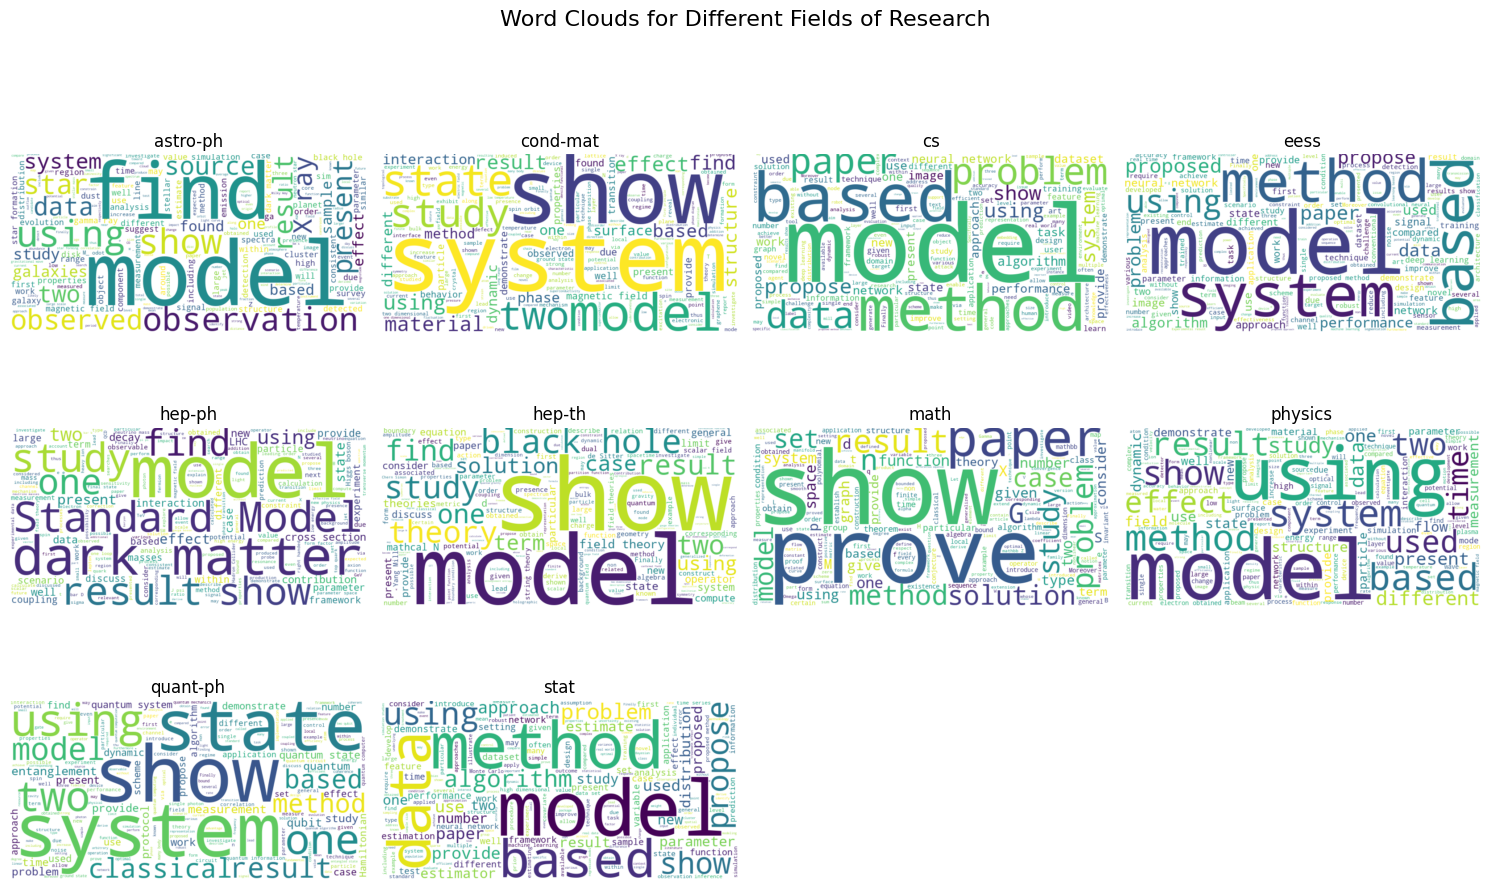

In [8]:
# Concatenate abstracts based on class labels
abstracts_by_class = {}
for label, group in train_data.groupby('label'):
    abstracts_by_class[label] = ' '.join(group['abstract'])

# Generate and plot word clouds for each class
plt.figure(figsize=(15, 10))
for i, (label, abstracts) in enumerate(abstracts_by_class.items(), start=1):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(abstracts)
    plt.subplot(3, 4, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(label)
    plt.axis('off')
plt.suptitle('Word Clouds for Different Fields of Research', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


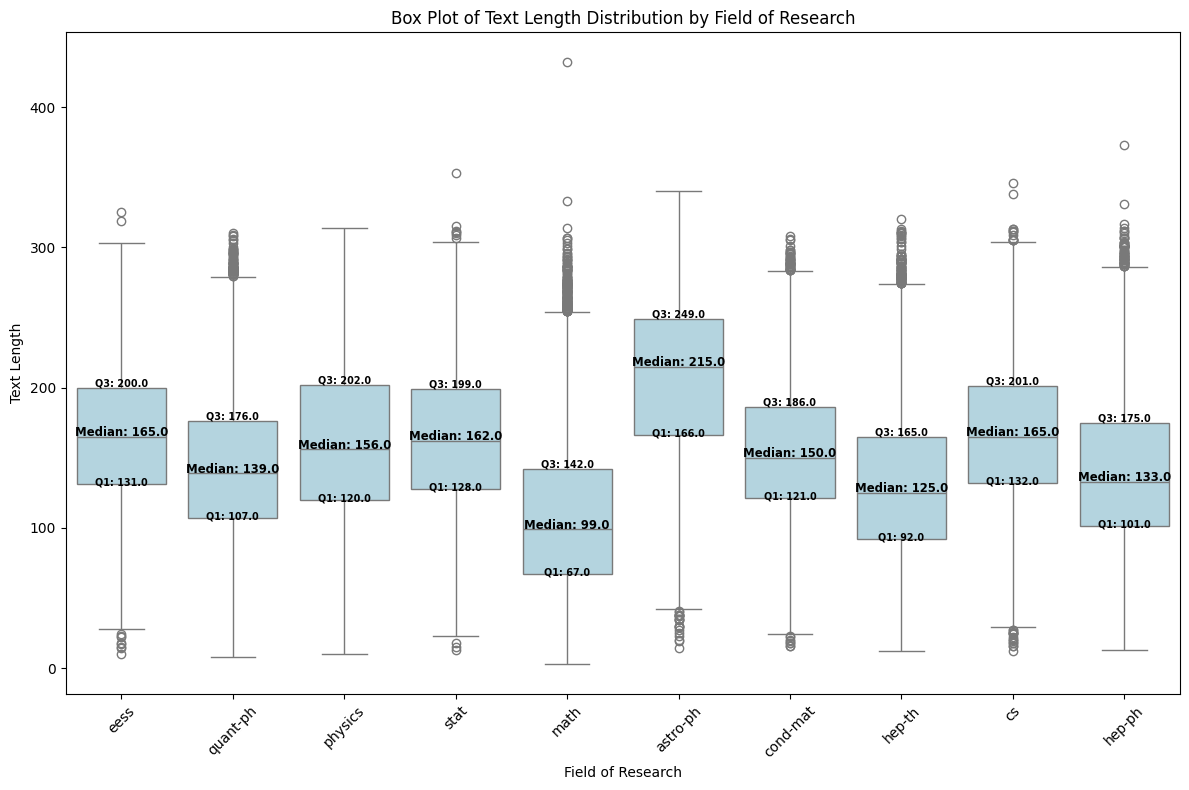

In [9]:
# Calculate text lengths if not already calculated
if 'text_length' not in train_data.columns:
    train_data['text_length'] = train_data['abstract'].apply(lambda x: len(x.split()))

# Calculate medians and quartiles if not already calculated
if 'medians' not in locals() or 'quartiles' not in locals():
    medians = train_data.groupby('label')['text_length'].median()
    quartiles = train_data.groupby('label')['text_length'].quantile([0.25, 0.75]).unstack(level=1)

# Plotting Box Plot
plt.figure(figsize=(12, 8))
box = sns.boxplot(data=train_data, x='label', y='text_length', color='lightblue')
plt.xticks(rotation=45)  # Helps if labels overlap or are too long

# Annotate with median, Q1, and Q3 values
labels = train_data['label'].unique()
for i, label in enumerate(labels):
    median = medians.loc[label]
    q1 = quartiles.loc[label][0.25]
    q3 = quartiles.loc[label][0.75]

    # Display median
    box.text(i, median + 0.5, f'Median: {median}', horizontalalignment='center', size='small', color='black', weight='semibold')
    
    # Display Q1
    box.text(i, q1 - 1, f'Q1: {q1}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
    
    # Display Q3
    box.text(i, q3 + 1, f'Q3: {q3}', horizontalalignment='center', size='x-small', color='black', weight='semibold')

plt.title('Box Plot of Text Length Distribution by Field of Research')
plt.xlabel('Field of Research')
plt.ylabel('Text Length')
plt.tight_layout()
plt.show()

In [10]:
# Define the bags-of-words representations
count_vectorizer = CountVectorizer(max_features=5000)  # Adjust max_features as needed
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed


In [11]:
# Convert abstracts into feature vectors
X_train_count = count_vectorizer.fit_transform(train_data['clean_abstract']).toarray()
X_test_count = count_vectorizer.transform(test_data['clean_abstract']).toarray()

In [12]:
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['clean_abstract']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['clean_abstract']).toarray()


In [13]:
# Define the labels
label_encoder = {label: idx for idx, label in enumerate(train_data['label'].unique())}
train_data['label_encoded'] = train_data['label'].map(label_encoder)
test_data['label_encoded'] = test_data['label'].map(label_encoder)

In [14]:
# Convert labels to PyTorch tensors
y_train = torch.tensor(train_data['label_encoded'].values)
y_test = torch.tensor(test_data['label_encoded'].values)


In [15]:
# Define train and test datasets
train_dataset_count = CustomDataset(X_train_count, y_train)
test_dataset_count = CustomDataset(X_test_count, y_test)

train_dataset_tfidf = CustomDataset(X_train_tfidf, y_train)
test_dataset_tfidf = CustomDataset(X_test_tfidf, y_test)

# Define data loaders
train_loader_count = DataLoader(train_dataset_count, batch_size=64, shuffle=True)
test_loader_count = DataLoader(test_dataset_count, batch_size=64, shuffle=False)

train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=64, shuffle=True)
test_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=64, shuffle=False)


# FFNN

In [16]:
ffnn_evaluation_result = []
activation_functions = [nn.LeakyReLU(), nn.ELU(), nn.Sigmoid(), nn.Softmax(dim=1)]
vectorizers = {
    'count': (X_train_count, train_loader_count, test_loader_count),
    'tfidf': (X_train_tfidf, train_loader_tfidf, test_loader_tfidf)
}
layer_configs = [1, 2, 3]

### Evaluating different number of layers for CountVectorizer and TFIDF feature detection method


In [17]:
def train_and_evaluate_model(vectorizer_name, input_size, output_size, layers, train_loader, test_loader):
    print(f"Training FFNN with {vectorizer_name} and {layers} layers")
    model = FFNN(input_size, 256, output_size, layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, criterion, optimizer, train_loader, num_epochs=10)
    results = evaluate_model(model, test_loader, f"{vectorizer_name[:2].upper()}_L{layers}")
    ffnn_evaluation_result.append(results)

for vectorizer, data in vectorizers.items():
    input_size = data[0].shape[1]
    output_size = len(label_encoder)
    
    for layers in layer_configs:
        train_and_evaluate_model(vectorizer, input_size, output_size, layers, data[1], data[2])


Training FFNN with count and 1 layers


Training Progress: 100%|██████████|[00:41, Epoch=10, Loss=381.69]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 81.12% |
|  F1 Score | 81.09% |
| Precision | 81.13% |
|   Recall  | 81.07% |
+-----------+--------+
Training FFNN with count and 2 layers


Training Progress: 100%|██████████|[00:39, Epoch=10, Loss=10.45]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 82.06% |
|  F1 Score | 81.99% |
| Precision | 82.05% |
|   Recall  | 82.02% |
+-----------+--------+
Training FFNN with count and 3 layers


Training Progress: 100%|██████████|[00:42, Epoch=10, Loss=19.55]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 81.36% |
|  F1 Score | 81.12% |
| Precision | 81.17% |
|   Recall  | 81.31% |
+-----------+--------+
Training FFNN with tfidf and 1 layers


Training Progress: 100%|██████████|[00:38, Epoch=10, Loss=560.79]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 83.30% |
|  F1 Score | 83.22% |
| Precision | 83.22% |
|   Recall  | 83.25% |
+-----------+--------+
Training FFNN with tfidf and 2 layers


Training Progress: 100%|██████████|[00:47, Epoch=10, Loss=935.02]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 58.53% |
|  F1 Score | 52.33% |
| Precision | 49.67% |
|   Recall  | 58.54% |
+-----------+--------+
Training FFNN with tfidf and 3 layers


Training Progress: 100%|██████████|[00:55, Epoch=10, Loss=2055.74]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 33.76% |
|  F1 Score | 26.73% |
| Precision | 25.64% |
|   Recall  | 34.04% |
+-----------+--------+


### Evaluating Activation Functions for CountVectorizer and TFIDF feature detection method

In [19]:
def train_and_evaluate_ffnn(vectorizer_name, input_size, output_size, train_loader, test_loader, activation_functions):
    for activation_function in activation_functions:
        activation_name = activation_function.__class__.__name__
        print(f"Training FFNN with {vectorizer_name} and {activation_name} as an activation function")
        tag = f"{vectorizer_name[:2].upper()}_{activation_name}"

        ffnn = FFNN(input_size, 256, output_size, num_layers=2, activation=activation_function)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(ffnn.parameters(), lr=0.001)

        train_model(ffnn, criterion, optimizer, train_loader, num_epochs=10)
        results = evaluate_model(ffnn, test_loader, tag)
        ffnn_evaluation_result.append(results)
        

# Parameters for CountVectorizer
input_size_count = X_train_count.shape[1]
output_size_count = len(label_encoder)
train_and_evaluate_ffnn("CountVectorizer", input_size_count, output_size_count, train_loader_count, test_loader_count, activation_functions)

# Parameters for TFIDF
input_size_tfidf = X_train_tfidf.shape[1]
output_size_tfidf = len(label_encoder)
train_and_evaluate_ffnn("TFIDF", input_size_tfidf, output_size_tfidf, train_loader_tfidf, test_loader_tfidf, activation_functions)

Training FFNN with CountVectorizer and LeakyReLU as an activation function


Training Progress: 100%|██████████|[00:38, Epoch=10, Loss=9.33] 


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 81.36% |
|  F1 Score | 81.28% |
| Precision | 81.28% |
|   Recall  | 81.30% |
+-----------+--------+
Training FFNN with CountVectorizer and ELU as an activation function


Training Progress: 100%|██████████|[00:39, Epoch=10, Loss=15.62]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 81.20% |
|  F1 Score | 81.10% |
| Precision | 81.10% |
|   Recall  | 81.17% |
+-----------+--------+
Training FFNN with CountVectorizer and Sigmoid as an activation function


Training Progress: 100%|██████████|[00:39, Epoch=10, Loss=1885.10]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 82.73% |
|  F1 Score | 82.63% |
| Precision | 82.65% |
|   Recall  | 82.69% |
+-----------+--------+
Training FFNN with CountVectorizer and Softmax as an activation function


Training Progress: 100%|██████████|[00:39, Epoch=10, Loss=2181.84]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 67.33% |
|  F1 Score | 62.65% |
| Precision | 69.70% |
|   Recall  | 67.05% |
+-----------+--------+
Training FFNN with TFIDF and LeakyReLU as an activation function


Training Progress: 100%|██████████|[00:38, Epoch=10, Loss=89.20]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.75% |
|  F1 Score | 80.65% |
| Precision | 80.69% |
|   Recall  | 80.71% |
+-----------+--------+
Training FFNN with TFIDF and ELU as an activation function


Training Progress: 100%|██████████|[00:40, Epoch=10, Loss=316.26]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 79.75% |
|  F1 Score | 79.59% |
| Precision | 79.57% |
|   Recall  | 79.69% |
+-----------+--------+
Training FFNN with TFIDF and Sigmoid as an activation function


Training Progress: 100%|██████████|[00:36, Epoch=10, Loss=1932.63]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 82.84% |
|  F1 Score | 82.76% |
| Precision | 82.79% |
|   Recall  | 82.80% |
+-----------+--------+
Training FFNN with TFIDF and Softmax as an activation function


Training Progress: 100%|██████████|[00:37, Epoch=10, Loss=2032.74]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 82.61% |
|  F1 Score | 82.41% |
| Precision | 82.45% |
|   Recall  | 82.58% |
+-----------+--------+


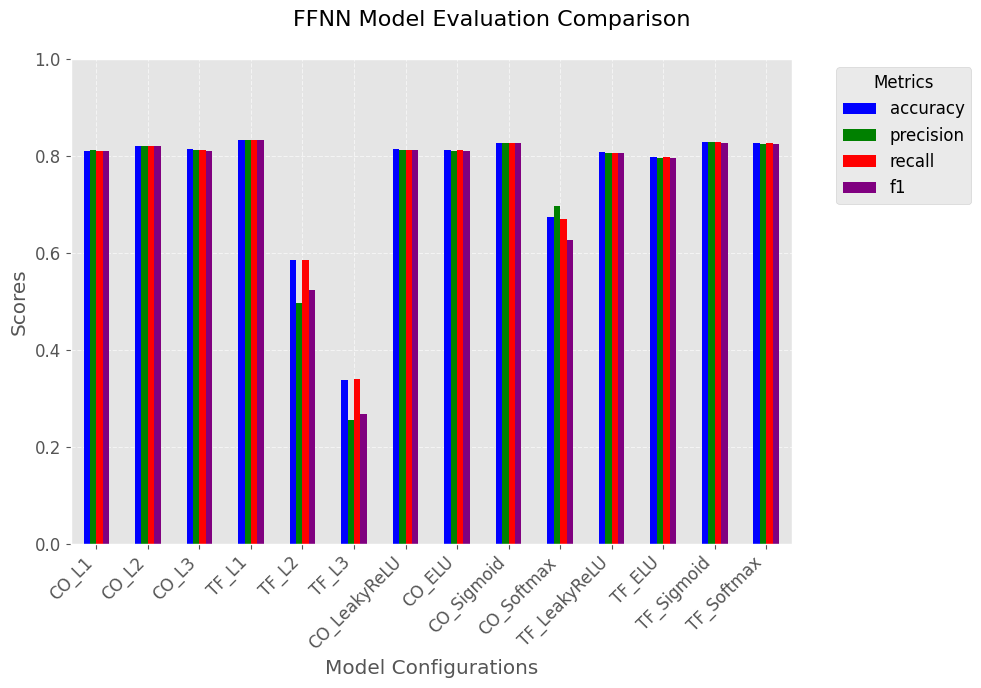

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation
df = pd.DataFrame(ffnn_evaluation_result)
df.set_index('tag', inplace=True)

# Styling and configuration
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

# Define custom colors for each metric, optional
color_dict = {'accuracy': 'blue', 'precision': 'green', 'recall': 'red', 'f1': 'purple'}

# Plotting
ax = df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', figsize=(10, 7), color=[color_dict.get(x) for x in ['accuracy', 'precision', 'recall', 'f1']])
ax.set_ylim(0, 1)
ax.set_xlabel('Model Configurations')
ax.set_ylabel('Scores')
ax.figure.suptitle('FFNN Model Evaluation Comparison', fontsize=16)
plt.xticks(rotation=45, ha='right')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Model for evaluating batch size


In [23]:
from tqdm import tqdm

num_epochs = 10
learning_rate = 0.001
batch_sizes = [32, 64, 128, 256]

input_size_count = X_train_count.shape[1]
output_size_count = len(label_encoder)

for batch_size in batch_sizes:
    print(f"Evaluating with batch size: {batch_size}")
    
    model = FFNN(input_size_count, 256, output_size_count, num_layers=2, activation=nn.ReLU())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader_count = DataLoader(train_dataset_count, batch_size, shuffle=True)
    test_loader_count = DataLoader(test_dataset_count, batch_size, shuffle=False)
    
    train_model(model, criterion, optimizer, train_loader_count, num_epochs=10)    
    tag = f"Batch size: {batch_size}"
    evaluate_model(model, test_loader_count, tag)


Evaluating with batch size: 32


Training Progress: 100%|██████████|[01:06, Epoch=10, Loss=2998.58]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 49.40% |
|  F1 Score | 43.05% |
| Precision | 41.52% |
|   Recall  | 49.44% |
+-----------+--------+
Evaluating with batch size: 64


Training Progress: 100%|██████████|[00:36, Epoch=10, Loss=635.10]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 72.19% |
|  F1 Score | 69.56% |
| Precision | 68.01% |
|   Recall  | 72.21% |
+-----------+--------+
Evaluating with batch size: 128


Training Progress: 100%|██████████|[00:23, Epoch=10, Loss=148.70]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 72.80% |
|  F1 Score | 70.04% |
| Precision | 68.58% |
|   Recall  | 72.82% |
+-----------+--------+
Evaluating with batch size: 256


Training Progress: 100%|██████████|[00:13, Epoch=10, Loss=79.80]

+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 73.59% |
|  F1 Score | 70.58% |
| Precision | 68.57% |
|   Recall  | 73.73% |
+-----------+--------+


In [30]:
def train_and_evaluate_model(input_size, output_size, train_dataset, test_dataset, vectorizer_name):
    num_epochs = 10
    learning_rate = 0.001
    batch_sizes = [32, 64, 128, 256]

    for batch_size in batch_sizes:
        print(f"Evaluating with {vectorizer_name} and batch size: {batch_size}")
        
        # Initialize model, criterion, and optimizer
        model = FFNN(input_size, 256, output_size, num_layers=2, activation=nn.ReLU())
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Prepare data loaders
        train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

        train_model(model, criterion, optimizer, train_loader_count, num_epochs) 
        # Evaluate the model after training
        tag = f"{vectorizer_name}_batch_{batch_size}"
        evaluate_model(model, test_loader, tag)

input_size_count = X_train_count.shape[1]
output_size_count = len(label_encoder)
results_count = train_and_evaluate_model(input_size_count, output_size_count, train_dataset_count, test_dataset_count, "CountVectorizer")

input_size_tfidf = X_train_tfidf.shape[1]
results_tfidf = train_and_evaluate_model(input_size_tfidf, output_size_count, train_dataset_tfidf, test_dataset_tfidf, "TFIDF")


Evaluating with CountVectorizer and batch size: 32


Training Progress: 100%|██████████|[00:13, Epoch=10, Loss=85.37]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 81.05% |
|  F1 Score | 80.94% |
| Precision | 81.09% |
|   Recall  | 80.97% |
+-----------+--------+
Evaluating with CountVectorizer and batch size: 64


Training Progress: 100%|██████████|[00:13, Epoch=10, Loss=84.16]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 74.44% |
|  F1 Score | 71.33% |
| Precision | 69.71% |
|   Recall  | 74.18% |
+-----------+--------+
Evaluating with CountVectorizer and batch size: 128


Training Progress: 100%|██████████|[00:13, Epoch=10, Loss=79.81]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 74.48% |
|  F1 Score | 71.51% |
| Precision | 69.49% |
|   Recall  | 74.68% |
+-----------+--------+
Evaluating with CountVectorizer and batch size: 256


Training Progress: 100%|██████████|[00:13, Epoch=10, Loss=5.09] 


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 81.63% |
|  F1 Score | 81.52% |
| Precision | 81.49% |
|   Recall  | 81.58% |
+-----------+--------+
Evaluating with TFIDF and batch size: 32


Training Progress: 100%|██████████|[00:13, Epoch=10, Loss=5.15] 


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 48.52% |
|  F1 Score | 51.29% |
| Precision | 78.55% |
|   Recall  | 48.27% |
+-----------+--------+
Evaluating with TFIDF and batch size: 64


Training Progress: 100%|██████████|[00:13, Epoch=10, Loss=79.37]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 42.00% |
|  F1 Score | 42.69% |
| Precision | 66.34% |
|   Recall  | 41.83% |
+-----------+--------+
Evaluating with TFIDF and batch size: 128


Training Progress: 100%|██████████|[00:13, Epoch=10, Loss=227.30]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 34.90% |
|  F1 Score | 32.08% |
| Precision | 49.63% |
|   Recall  | 34.79% |
+-----------+--------+
Evaluating with TFIDF and batch size: 256


Training Progress: 100%|██████████|[00:13, Epoch=10, Loss=78.37]

+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 43.02% |
|  F1 Score | 43.59% |
| Precision | 68.69% |
|   Recall  | 42.79% |
+-----------+--------+


# Model for regularization

In [31]:
class FFNN_regularization(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(FFNN_regularization, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [36]:
def train_and_evaluate(input_size, output_size, train_loader, test_loader, vectorizer_name):
    print(f"Evaluating with {vectorizer_name}")
    
    model = FFNN_regularization(input_size, 256, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_model(model, criterion, optimizer, train_loader, num_epochs=10)
    tag = f"{vectorizer_name}_batch_{batch_size}"
    evaluate_model(model, test_loader, tag)
    print()

# Parameters
output_size_count = len(label_encoder)  # This only needs to be defined once

# Training and evaluating with Count Vectorizer data
input_size_count = X_train_count.shape[1]
train_and_evaluate(input_size_count, output_size_count, train_loader_count, test_loader_count, "CountVectorizer")

# Training and evaluating with TF-IDF data
input_size_tfidf = X_train_tfidf.shape[1]
train_and_evaluate(input_size_tfidf, output_size_count, train_loader_tfidf, test_loader_tfidf, "TFIDF")


Evaluating with CountVectorizer


Training Progress: 100%|██████████|[00:14, Epoch=10, Loss=31.65]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 82.77% |
|  F1 Score | 82.66% |
| Precision | 82.64% |
|   Recall  | 82.72% |
+-----------+--------+

Evaluating with TFIDF


Training Progress: 100%|██████████|[00:38, Epoch=10, Loss=158.31]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 82.58% |
|  F1 Score | 82.47% |
| Precision | 82.49% |
|   Recall  | 82.54% |
+-----------+--------+



# RNN


In [38]:
rnn_evaluation_result = []

### Evaluating different number of layers for CountVectorizer and TFIDF feature detection method


In [39]:
def train_and_evaluate_model(vectorizer_name, input_size, output_size, layers, train_loader, test_loader):
    print(f"Training RNN with {vectorizer_name} and {layers} layers")
    model = RNN(input_size, 256, output_size, layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, criterion, optimizer, train_loader, num_epochs=10)
    results = evaluate_model(model, test_loader, f"{vectorizer_name[:2].upper()}_L{layers}")
    rnn_evaluation_result.append(results)

for vectorizer, data in vectorizers.items():
    input_size = data[0].shape[1]
    output_size = len(label_encoder)
    
    for layers in layer_configs:
        train_and_evaluate_model(vectorizer, input_size, output_size, layers, data[1], data[2])


Training RNN with count and 1 layers


Training Progress: 100%|██████████|[02:12, Epoch=10, Loss=44.01]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.93% |
|  F1 Score | 80.79% |
| Precision | 80.90% |
|   Recall  | 80.90% |
+-----------+--------+
Training RNN with count and 2 layers


Training Progress: 100%|██████████|[03:46, Epoch=10, Loss=128.74]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.47% |
|  F1 Score | 80.39% |
| Precision | 80.46% |
|   Recall  | 80.42% |
+-----------+--------+
Training RNN with count and 3 layers


Training Progress: 100%|██████████|[05:18, Epoch=10, Loss=204.95]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.77% |
|  F1 Score | 80.61% |
| Precision | 80.63% |
|   Recall  | 80.69% |
+-----------+--------+
Training RNN with tfidf and 1 layers


Training Progress: 100%|██████████|[02:13, Epoch=10, Loss=389.61]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 79.88% |
|  F1 Score | 79.85% |
| Precision | 79.92% |
|   Recall  | 79.84% |
+-----------+--------+
Training RNN with tfidf and 2 layers


Training Progress: 100%|██████████|[03:39, Epoch=10, Loss=400.14]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 79.81% |
|  F1 Score | 79.65% |
| Precision | 79.71% |
|   Recall  | 79.79% |
+-----------+--------+
Training RNN with tfidf and 3 layers


Training Progress: 100%|██████████|[05:17, Epoch=10, Loss=456.19]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.30% |
|  F1 Score | 80.16% |
| Precision | 80.29% |
|   Recall  | 80.26% |
+-----------+--------+


### Evaluating Activation Functions for CountVectorizer and TFIDF feature detection method

In [40]:
def train_and_evaluate_rnn(vectorizer_name, input_size, output_size, train_loader, test_loader, activation_functions):
    for activation_function in activation_functions:
        activation_name = activation_function.__class__.__name__
        print(f"Training RNN with {vectorizer_name} and {activation_name} as an activation function")
        tag = f"{vectorizer_name[:2].upper()}_{activation_name}"

        rnn = RNN(input_size, 256, output_size, num_layers=2, activation=activation_function)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(rnn.parameters(), lr=0.001)

        train_model(rnn, criterion, optimizer, train_loader, num_epochs=10)
        results = evaluate_model(rnn, test_loader, tag)
        rnn_evaluation_result.append(results)
        

# Parameters for CountVectorizer
input_size_count = X_train_count.shape[1]
output_size_count = len(label_encoder)
train_and_evaluate_rnn("CountVectorizer", input_size_count, output_size_count, train_loader_count, test_loader_count, activation_functions)

# Parameters for TFIDF
input_size_tfidf = X_train_tfidf.shape[1]
output_size_tfidf = len(label_encoder)
train_and_evaluate_rnn("TFIDF", input_size_tfidf, output_size_tfidf, train_loader_tfidf, test_loader_tfidf, activation_functions)

Training RNN with CountVectorizer and LeakyReLU as an activation function


Training Progress: 100%|██████████|[03:08, Epoch=10, Loss=34.85]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.55% |
|  F1 Score | 80.44% |
| Precision | 80.46% |
|   Recall  | 80.51% |
+-----------+--------+
Training RNN with CountVectorizer and ELU as an activation function


Training Progress: 100%|██████████|[03:07, Epoch=10, Loss=35.32]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.57% |
|  F1 Score | 80.55% |
| Precision | 80.63% |
|   Recall  | 80.51% |
+-----------+--------+
Training RNN with CountVectorizer and Sigmoid as an activation function


Training Progress: 100%|██████████|[03:07, Epoch=10, Loss=474.69]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 82.15% |
|  F1 Score | 82.02% |
| Precision | 82.01% |
|   Recall  | 82.10% |
+-----------+--------+
Training RNN with CountVectorizer and Softmax as an activation function


Training Progress: 100%|██████████|[03:09, Epoch=10, Loss=488.00]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 81.47% |
|  F1 Score | 81.33% |
| Precision | 81.35% |
|   Recall  | 81.44% |
+-----------+--------+
Training RNN with TFIDF and LeakyReLU as an activation function


Training Progress: 100%|██████████|[03:47, Epoch=10, Loss=397.10]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.38% |
|  F1 Score | 80.09% |
| Precision | 80.32% |
|   Recall  | 80.35% |
+-----------+--------+
Training RNN with TFIDF and ELU as an activation function


Training Progress: 100%|██████████|[03:46, Epoch=10, Loss=399.76]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.50% |
|  F1 Score | 80.34% |
| Precision | 80.41% |
|   Recall  | 80.47% |
+-----------+--------+
Training RNN with TFIDF and Sigmoid as an activation function


Training Progress: 100%|██████████|[03:46, Epoch=10, Loss=1938.82]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 81.31% |
|  F1 Score | 81.21% |
| Precision | 81.37% |
|   Recall  | 81.27% |
+-----------+--------+
Training RNN with TFIDF and Softmax as an activation function


Training Progress: 100%|██████████|[03:46, Epoch=10, Loss=2001.21]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.27% |
|  F1 Score | 80.18% |
| Precision | 80.30% |
|   Recall  | 80.24% |
+-----------+--------+


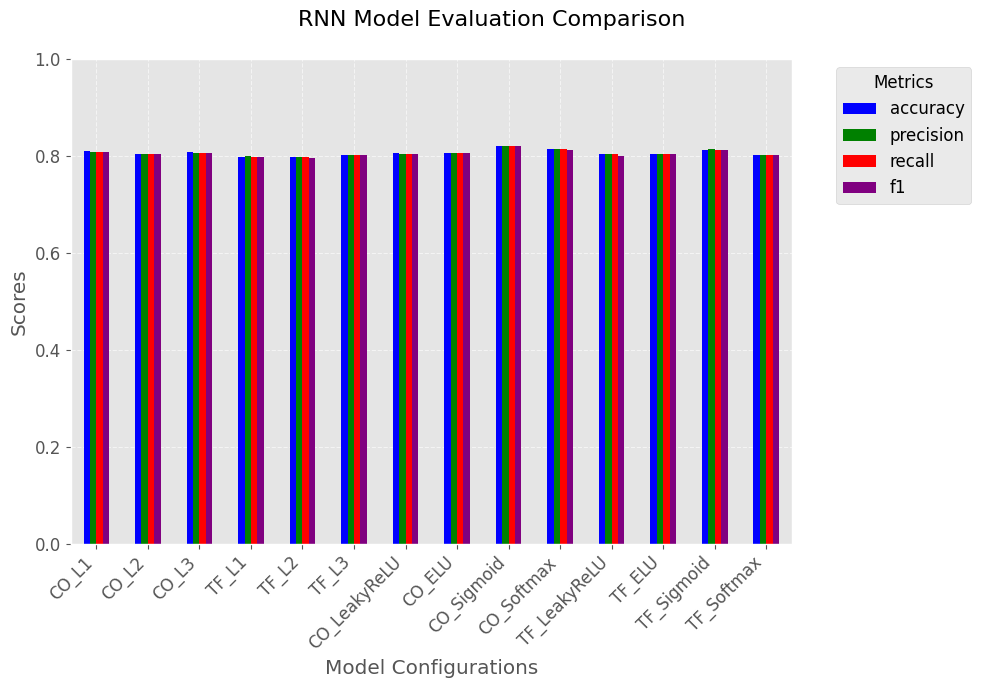

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation
df = pd.DataFrame(rnn_evaluation_result)
df.set_index('tag', inplace=True)

# Styling and configuration
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

# Define custom colors for each metric, optional
color_dict = {'accuracy': 'blue', 'precision': 'green', 'recall': 'red', 'f1': 'purple'}

# Plotting
ax = df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', figsize=(10, 7), color=[color_dict.get(x) for x in ['accuracy', 'precision', 'recall', 'f1']])
ax.set_ylim(0, 1)
ax.set_xlabel('Model Configurations')
ax.set_ylabel('Scores')
ax.figure.suptitle('RNN Model Evaluation Comparison', fontsize=16)
plt.xticks(rotation=45, ha='right')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Model for evaluating batch size


In [50]:
def train_and_evaluate_model(input_size, output_size, train_dataset, test_dataset, vectorizer_name):
    num_epochs = 10
    learning_rate = 0.001
    batch_sizes = [32, 64, 128, 256]

    for batch_size in batch_sizes:
        print(f"Evaluating with {vectorizer_name} and batch size: {batch_size}")
        
        # Initialize model, criterion, and optimizer
        model = RNN(input_size, 256, output_size, num_layers=2, activation=nn.ReLU())
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Prepare data loaders
        train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

        train_model(model, criterion, optimizer, train_loader, num_epochs) 
        # Evaluate the model after training
        tag = f"{vectorizer_name}_batch_{batch_size}"
        evaluate_model(model, test_loader, tag)

input_size_count = X_train_count.shape[1]
output_size_count = len(label_encoder)
results_count = train_and_evaluate_model(input_size_count, output_size_count, train_dataset_count, test_dataset_count, "CountVectorizer")

input_size_tfidf = X_train_tfidf.shape[1]
results_tfidf = train_and_evaluate_model(input_size_tfidf, output_size_count, train_dataset_tfidf, test_dataset_tfidf, "TFIDF")


Evaluating with CountVectorizer and batch size: 32


Training Progress: 100%|██████████|[04:26, Epoch=10, Loss=343.53]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.27% |
|  F1 Score | 80.16% |
| Precision | 80.19% |
|   Recall  | 80.20% |
+-----------+--------+
Evaluating with CountVectorizer and batch size: 64


Training Progress: 100%|██████████|[03:45, Epoch=10, Loss=129.30]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.53% |
|  F1 Score | 80.41% |
| Precision | 80.44% |
|   Recall  | 80.48% |
+-----------+--------+
Evaluating with CountVectorizer and batch size: 128


Training Progress: 100%|██████████|[03:22, Epoch=10, Loss=61.13]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 81.05% |
|  F1 Score | 80.95% |
| Precision | 80.95% |
|   Recall  | 81.00% |
+-----------+--------+
Evaluating with CountVectorizer and batch size: 256


Training Progress: 100%|██████████|[03:07, Epoch=10, Loss=34.60]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.44% |
|  F1 Score | 80.19% |
| Precision | 80.30% |
|   Recall  | 80.40% |
+-----------+--------+
Evaluating with TFIDF and batch size: 32


Training Progress: 100%|██████████|[04:24, Epoch=10, Loss=868.32]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.01% |
|  F1 Score | 79.85% |
| Precision | 79.84% |
|   Recall  | 79.97% |
+-----------+--------+
Evaluating with TFIDF and batch size: 64


Training Progress: 100%|██████████|[03:42, Epoch=10, Loss=400.54]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.46% |
|  F1 Score | 80.31% |
| Precision | 80.61% |
|   Recall  | 80.43% |
+-----------+--------+
Evaluating with TFIDF and batch size: 128


Training Progress: 100%|██████████|[03:21, Epoch=10, Loss=189.11]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.51% |
|  F1 Score | 80.26% |
| Precision | 80.22% |
|   Recall  | 80.45% |
+-----------+--------+
Evaluating with TFIDF and batch size: 256


Training Progress: 100%|██████████|[03:04, Epoch=10, Loss=90.22]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.34% |
|  F1 Score | 80.28% |
| Precision | 80.36% |
|   Recall  | 80.31% |
+-----------+--------+


# Model for regularization

In [48]:
class RNN_Regularized(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_rate=0.2, activation=nn.ReLU()):
        super(RNN_Regularized, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = activation  # Store the activation function

    def forward(self, x):
        # Assuming x has shape [batch_size, seq_len, input_size]
        out, _ = self.rnn(x)

        # Handling output dimensions depending on whether it's 2D or 3D
        if out.dim() == 3:  # [batch_size, seq_len, hidden_size]
            out = out[:, -1, :]  # Take the last time step
        elif out.dim() != 2:  # [batch_size, hidden_size]
            raise ValueError("Unexpected output shape from RNN layer")

        out = self.fc(out)  # Apply the linear transformation
        out = self.activation(out)  # Apply the activation function
        return out

In [49]:
def train_and_evaluate(input_size, output_size, train_loader, test_loader, vectorizer_name):
    print(f"Evaluating with {vectorizer_name}")
    
    model = RNN_Regularized(input_size, 256, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_model(model, criterion, optimizer, train_loader, num_epochs=10)
    tag = f"{vectorizer_name}_batch_{batch_size}"
    evaluate_model(model, test_loader, tag)
    print()

# Parameters
output_size_count = len(label_encoder)  # This only needs to be defined once

# Training and evaluating with Count Vectorizer data
input_size_count = X_train_count.shape[1]
train_and_evaluate(input_size_count, output_size_count, train_loader_count, test_loader_count, "CountVectorizer")

# Training and evaluating with TF-IDF data
input_size_tfidf = X_train_tfidf.shape[1]
train_and_evaluate(input_size_tfidf, output_size_count, train_loader_tfidf, test_loader_tfidf, "TFIDF")


Evaluating with CountVectorizer


Training Progress: 100%|██████████|[03:07, Epoch=10, Loss=60.28]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 81.33% |
|  F1 Score | 81.21% |
| Precision | 81.21% |
|   Recall  | 81.28% |
+-----------+--------+

Evaluating with TFIDF


Training Progress: 100%|██████████|[03:47, Epoch=10, Loss=420.32]


+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 80.91% |
|  F1 Score | 80.74% |
| Precision | 81.00% |
|   Recall  | 80.88% |
+-----------+--------+

